# 2333084 梁潇怡

## Dataset 

In this assignment, I used the IRIS and WINE dataset from the UCI Machine Learning Repository.

### IRIS
According to the official introduction, the dataset includes 4 attributes and 3 labels.

Attribute Information:

1. Sepal length in cm
2. Sepal width in cm
3. Petal length in cm
4. Petal width in cm
5. class:
      --Iris Setosa
      --Iris Versicour
      --Iris Virginia

Due to the inclusion of three types of labels, in this assignment, one label was manually removed to match the binary dataset, and then the seanborn library was used to visualize the dataset to visually determine if there were any issues. 

According to the visualization image, we can see that there are some obvious outliers in the measurement that may be incorrect, such as sepal_width has one or two points deviate from normal values, which may affect training. At the same time, sepal_width is not as distinct as the other three attributes, so it is considered to remove this attribute in model training and prediction.


In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import adjusted_rand_score


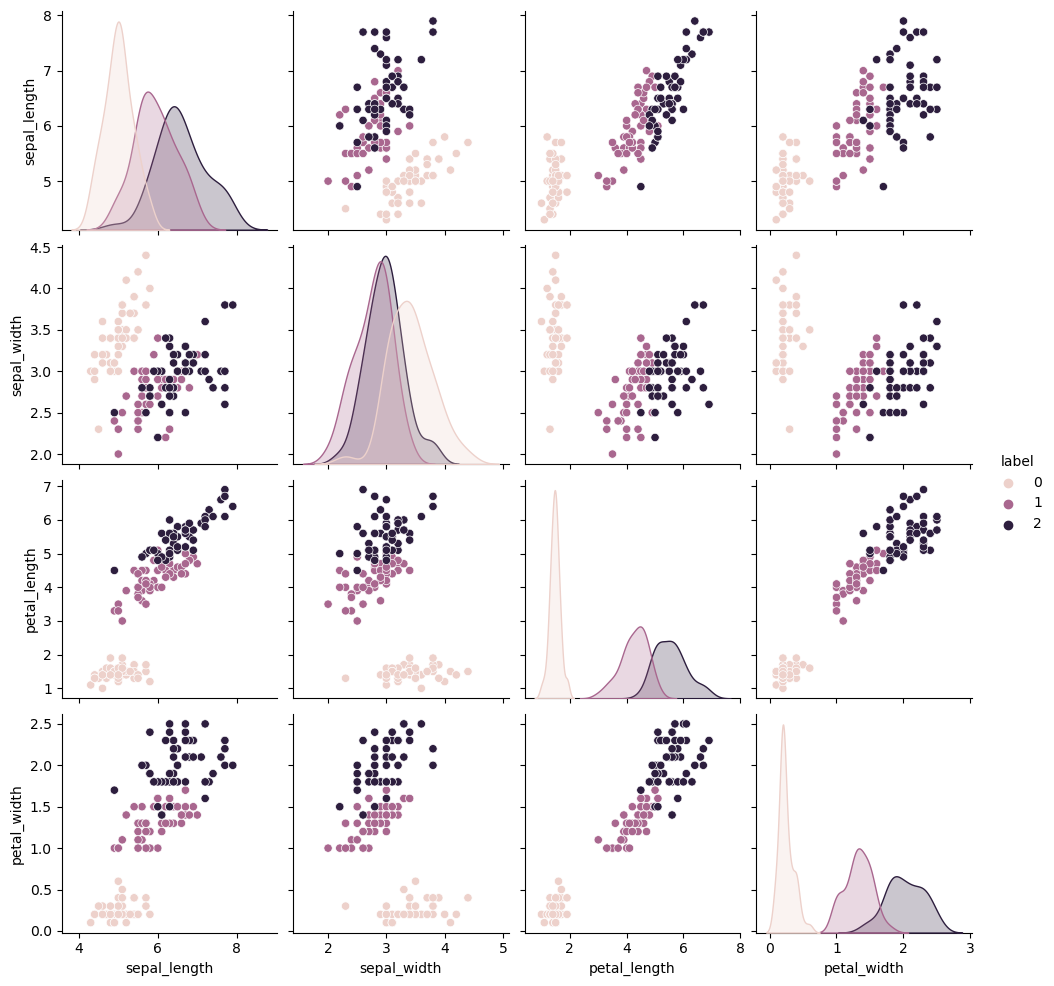

In [116]:
iris = pd.read_csv('./iris/iris.data',sep=',')
iris.columns=['sepal_length','sepal_width','petal_length','petal_width',"label"]
iris.label = pd.factorize(iris['label'])[0]
g=sns.pairplot(iris, hue='label')
plt.show()
iris = iris.to_numpy()


### WINE

These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. 

The attributes are (dontated by Riccardo Leardi, riclea@anchem.unige.it )
1) Alcohol
2) Malic acid
3) Ash
4) Alcalinity of ash  
5) Magnesium
6) Total phenols
7) Flavanoids
8) Nonflavanoid phenols
9) Proanthocyanins
10) Color intensity
11) Hue
12) OD280/OD315 of diluted wines
13) Proline 

## Gaussian mixture model
The Gaussian mixture model can be seen as a model composed of K single Gaussian models, and these K sub models are the hidden variables of the mixture model. Generally speaking, a mixed model can use any probability distribution, and using a Gaussian mixture model is because Gaussian distribution has good mathematical properties and good computational performance.

Calculating the parameters of a Gaussian mixture model cannot be differentiated using the maximum likelihood method like a single Gaussian model to obtain the parameter that maximizes the likelihood, because for each observation data point, it is not known in advance which sub distribution it belongs to (hidden variable). Therefore, there is also summation in the log, and for each sub model, there is an unknown value $\alpha_k, \mu_k, \sigma_k$.

Direct differentiation cannot be calculated. It needs to be solved through iterative methods.

### EM Algroithm

The EM algorithm is an iterative algorithm proposed by Dempster et al. in 1977 for maximum likelihood estimation of probability model parameters containing hidden variables.

Each iteration consists of two steps:

E-step: Seeking Expectations $E\left(\gamma_{j k} \mid X, \theta\right)$ for all $j=1,2, \ldots, N$

M-step: Maximize and calculate the model parameters for a new iteration




In [117]:
np.random.seed(42)

In [118]:
class GMM:
    def __init__(self, k):
        self.k = k
        self.mu = None
        self.sigma = None
        self.phi = None
    
    def fit(self, X, max_iter=1000):
        N, D = X.shape
        self.init_params(X)
        for _ in range(max_iter):
            self._e_step(X)
            self._m_step(X)

        
    def init_params(self, X):
        N, D = X.shape
        random_row = np.random.randint(low=0, high=N, size=self.k)
        self.mu = [X[row_index,:] for row_index in random_row]
        self.sigma = [np.cov(X.T) for _ in range(self.k)]
        self.phi = np.array([1.0 / self.k] * self.k)
        self.gamma = np.zeros((N, self.k))
    def _e_step(self, X):
        N, D = X.shape
        for i in range(self.k):
            self.gamma[:, i] = self.phi[i] * multivariate_normal.pdf(X, mean=self.mu[i], cov=self.sigma[i])
        self.gamma /= np.sum(self.gamma, axis=1)[:, np.newaxis]
    
    def _m_step(self, X):
        for i in range(self.k):
            weight = np.sum(self.gamma[:, i], axis=0)
            self.phi[i] = weight / X.shape[0]

            self.mu[i] = 1/weight * np.sum(self.gamma[:,i] * X.T, axis=1).T
            X_mu = X - self.mu[i]
            self.sigma[i] = 1/weight * np.dot(self.gamma[:,i] * X_mu.T, X_mu)

    def predict(self, X):
        N, D = X.shape
        pred = np.zeros((N, self.k))
        for i in range(self.k):
            pred[:, i] = self.phi[i] * multivariate_normal.pdf(X, self.mu[i], self.sigma[i])
        return np.argmax(pred, axis=1)
    
    def plot_contours(self, X):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        xx = np.c_[x_grid.ravel(), y_grid.ravel()]
        Z = np.zeros((xx.shape[0], self.k))
        for i in range(self.k):
            Z[:,i] = self.phi[i] * multivariate_normal.pdf(xx, mean=self.mu[i], cov=self.sigma[i])
        
        Z = np.log(np.sum(Z, axis=1))
        Z = Z.reshape(x_grid.shape)
        plt.contourf(x_grid, y_grid, Z, levels=10, cmap="coolwarm")
        plt.scatter(X[:, 0], X[:, 1], c=self.predict(X), alpha=0.8)
        plt.show()
    

## Result


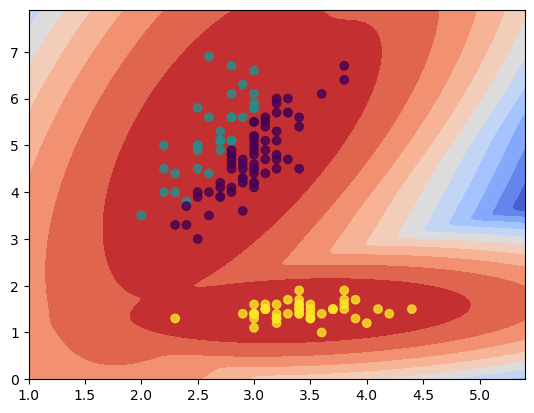

In [119]:

x_iris = iris[:,:4]
y_iris = iris[:,-1]

gmm = GMM(3)
gmm.fit(x_iris)

pred = gmm.predict(x_iris)
gmm.fit(x_iris[:,1:3])
gmm.plot_contours(x_iris[:,1:3])

Based on the classification results, draw a contour map of gamma, and it can be observed from the graph that the GMM model can cluster datasets well.

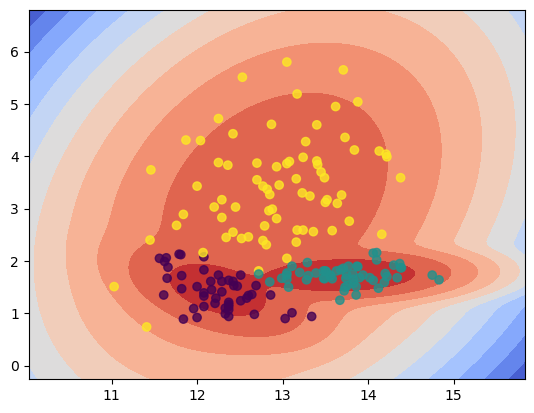

In [120]:
wine = pd.read_csv('./wine/wine.data',sep=',')
wine = wine.to_numpy()

x_wine = wine[:,1:-1]
y_wine = wine[:,0]

gmm = GMM(3)
gmm.fit(x_wine)
pred_wine = gmm.predict(x_wine)

gmm.fit(x_wine[:,:2])
gmm.plot_contours(x_wine[:,:2])

Based on the classification results, draw a contour map of gamma, and it can be observed from the graph that the GMM model can cluster datasets well.

## Limitation and Improvement

The current dataset lacks preprocessing stage, and some data lacks sufficient feature dimensionality reduction, which may not be able to better capture clustering for the model.

This hyper params should be defined carefully.




## How to Run
you need to prepare python enviroment and install:
- sklearn
- numpy
- matplotlib
- pandas
- seaborn
then click the run all.